In [18]:
# Compara el índice de precipitación y de otra variable.

import os

import rioxarray

import pandas as pd
import numpy as np
import matplotlib

import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [19]:
# Datos.
path_nc = "../results/CHIRPS_global_days_p05/cuenca_valle_mexico/"
path_shp = "../data/Cuencas/Regiones_Hidrologicas_Administrativas/"
names = ["cuenca_valle_mexico_chirps-v2.0.days_p05.nc", 
    "cuenca_valle_mexico_chirps-v2.0.2021.days_p05.nc",
    "rha250kgw.shp"]
path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

# Variable, nivel de presión y región.
vars = [ "u", "v", "gp", "sst", "olr", "sp", #"vidmf",
    "vivfu", "vivfv" ]
levels = [ "925", "200" ]
zones =  (-100, 0, -90, 10)
zones_w =  (-100, 0, -90, 10)
anom = [".", "_anom."]

# Datos a utilizar.
v = 0
n = 0
d = 20
a = anom[0]

# Criterios.
umbral_pre = [3, 3]
n_pre= [10, 10]
umbral_var = [0, 0]
n_var = [8, 6]

# Cantidad de días a promediar.
d = 20

# Si no existe la carpeta, la crea.
if not os.path.exists(path_r):
    os.mkdir(path_r)

# Información de precipitación
df = pd.read_csv(path_d + "pre_daily_CHIRPS.csv", index_col = "time" )
df.index = pd.to_datetime( df.index )

In [20]:
# Cargamos la variable.

# Variable a utilizar.
if v > 2: lev = ""
else: lev = "_" + levels[n]

# Viento zonal.
fname = ( "onset_" + vars[v] + lev
    + "_mean_" + str(d) + "_dias" + a + "grib" )
ds = xr.open_dataset( path_d + fname, engine = "cfgrib" )

if v < 3:
    ds = ds.drop_vars(["step", "isobaricInhPa", "valid_time"])
elif v < 6:
    ds = ds.drop_vars(["step", "surface", "valid_time"])
else:
    ds = ds.drop_vars(["step", "entireAtmosphere", "valid_time"])

# Seleccionamos la región.
clip = ds.sel( longitude = slice(zones[0], zones[2]), 
    latitude = slice(zones[3], zones[1]) ).copy()
clip_w = ds.sel( longitude = slice(zones_w[0], zones_w[2]), 
    latitude = slice(zones_w[3], zones_w[1]) ).copy()

# Precipitación diaria promedio en toda la cuenca.
df_var = ( clip.mean(dim = ["latitude", "longitude"]).to_dataframe() )
df_var.columns = ["Cuenca"]

df_var_w = ( clip_w.mean(dim = ["latitude", "longitude"]).to_dataframe() )
df_var_w.columns = ["Cuenca"]

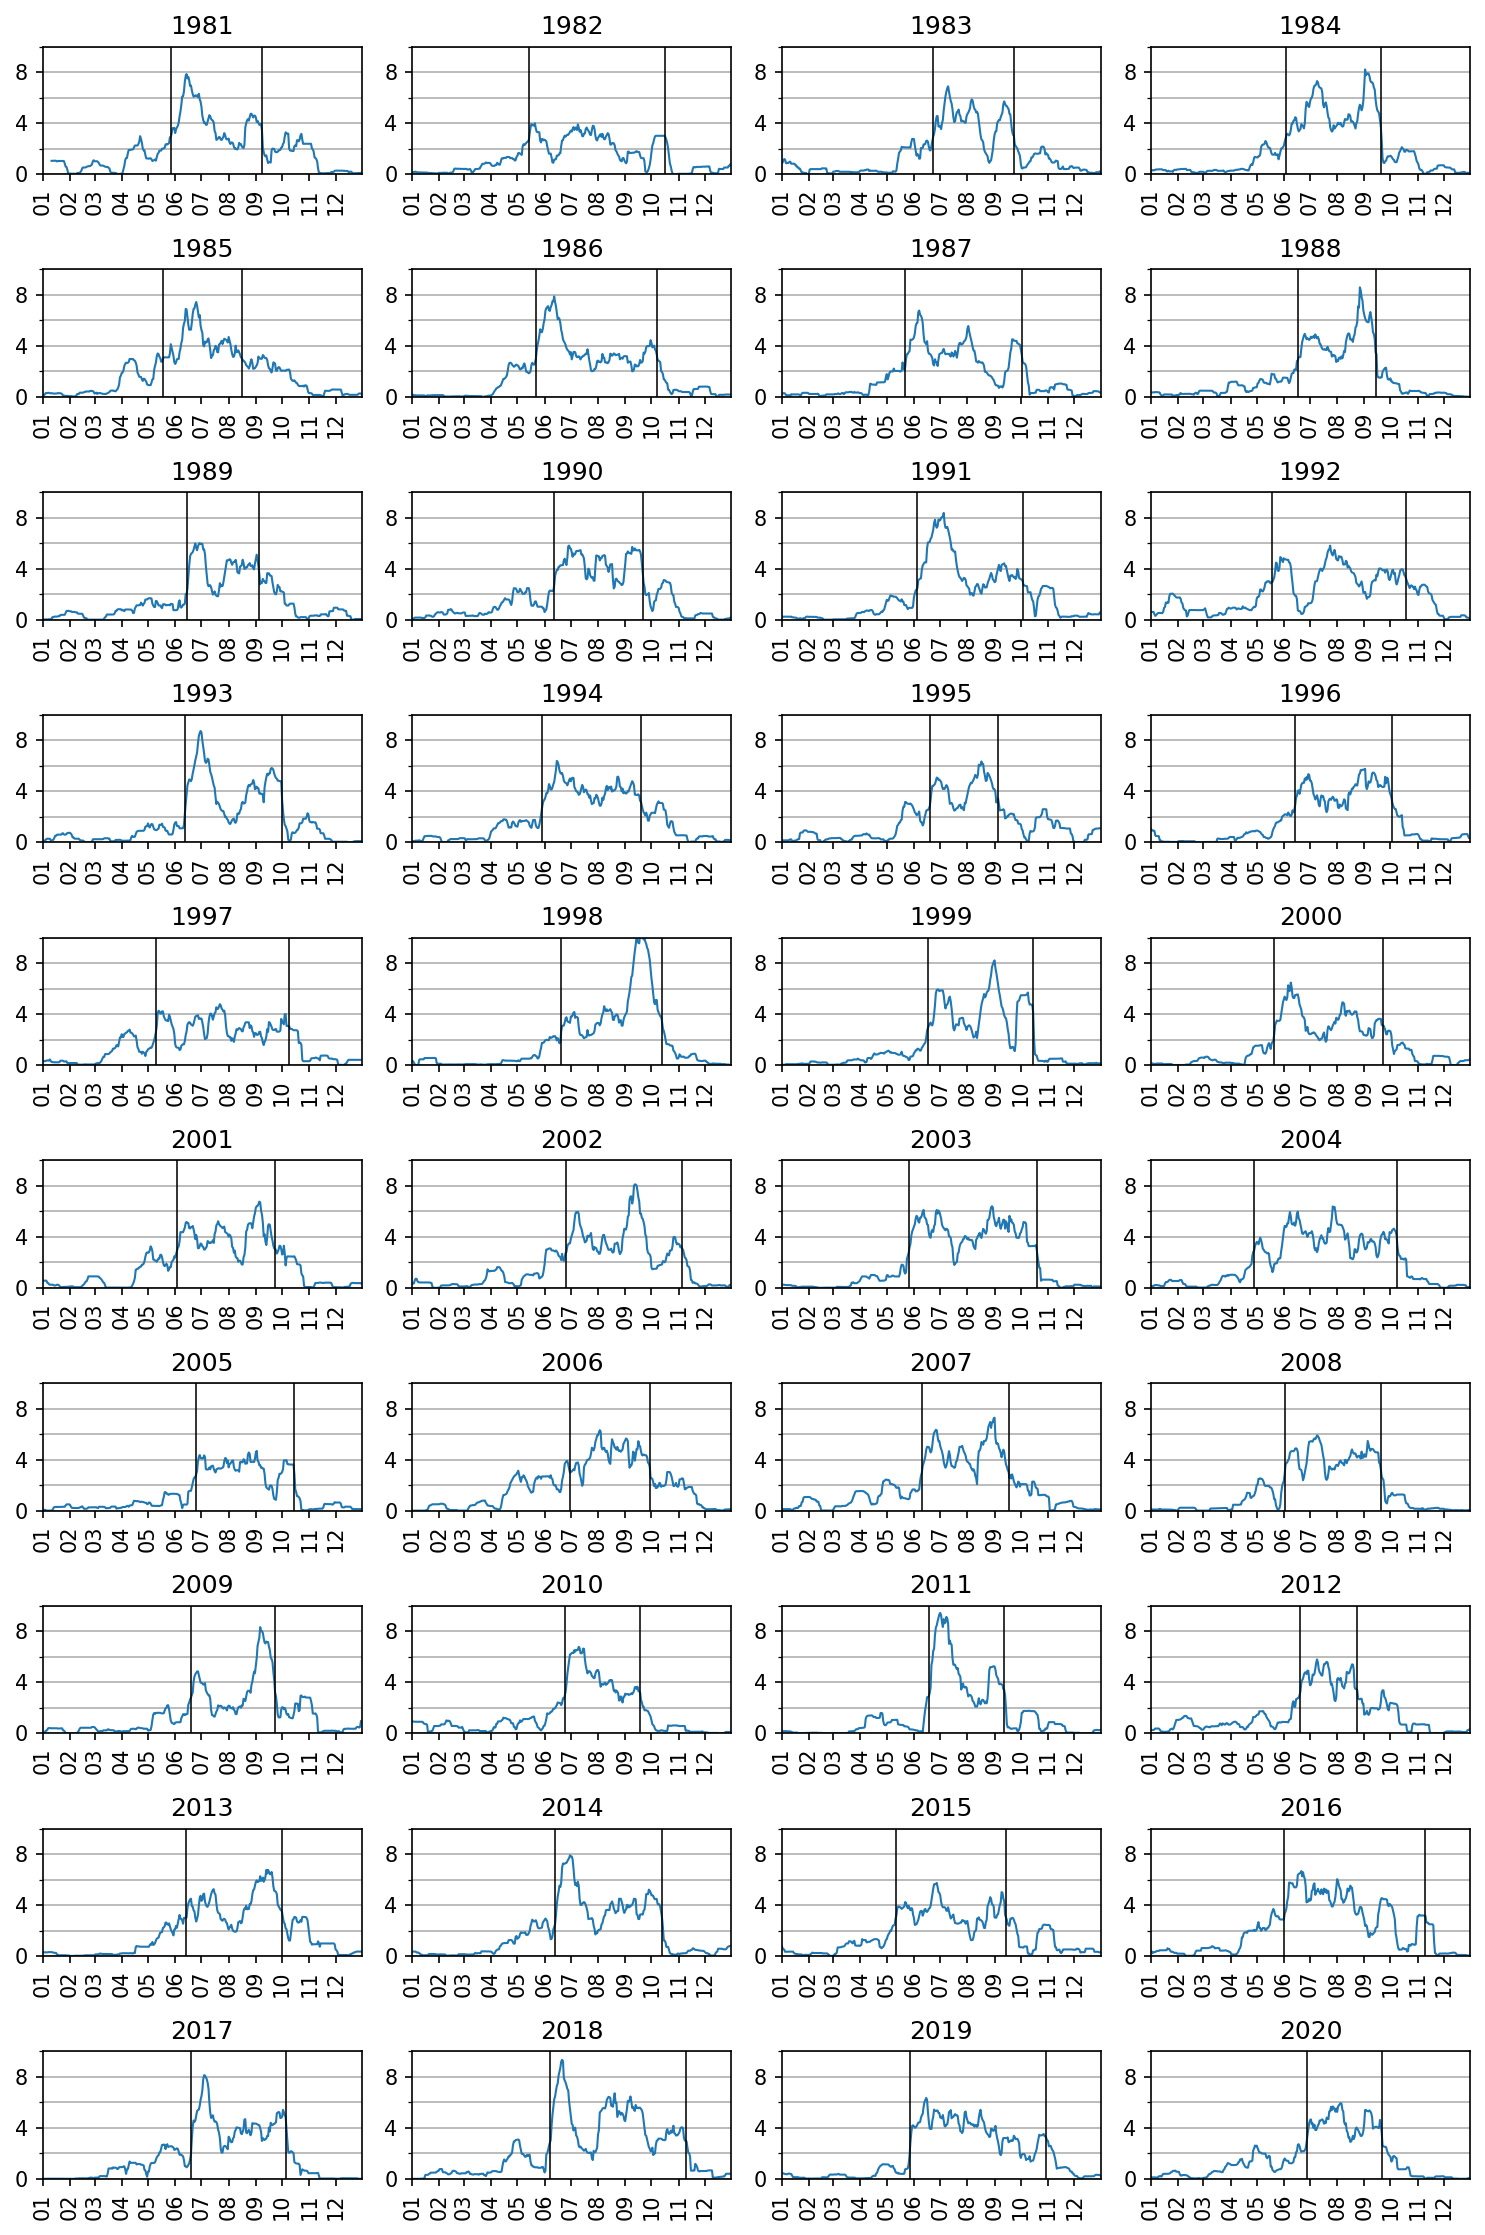

In [21]:
# Precipitación.

# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = umbral_pre
n = n_pre

m_i = 4

df = pd.DataFrame( df_pre.copy(), columns = ["Cuenca"] )

years = range(1981, 2021)
c = "Cuenca"
title = "onset_withdrawal_CHIRPS_diferente.png"

# Onset.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[0]): proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df[p] = df[proc[0]].shift(i)
    df[p].clip( upper = umbral[0], inplace = True )
    df[p] = df[p].where(df[p] == umbral[0], 0)
    df[p] = df[p].where(df[p] < umbral[0], 1)
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df[ind] = 0
for i in range(n[0]):
    df[ind] += df[proc[i + 1]]
df[ind] = df[ind].where( df[ind] == n[0], 0 )
df[ind] = df[ind].where( df[ind] < n[0], 1 )
df[ind] = df[ind].where( df.index.month.isin( range(5, 12) ), 0 )
df.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df[ (df.index.year == j) & df.index.month.isin(range(m_i, 12)) ]
    row = []
    # Fechas.
    row.append( df_year.iloc[:, 1].idxmax() )
    row.append( None )
    #row.append( df_year.iloc[::-1, 1].idxmax() )
    # Agregamos la fila al DataFrame.
    date = date.append([row])
# Recorremos al inicio de la racha de días de precipitación.
date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(n[0], 'D')

# Withdrawal.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[1]):
    proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df[p] = df[proc[0]].shift(i)
    df[p].clip( upper = umbral[1], inplace = True )
    df[p] = df[p].where(df[p] == umbral[1], 0)
    df[p] = df[p].where(df[p] < umbral[1], 1)
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df[ind] = 0
for i in range(n[1]):
    df[ind] += df[proc[i + 1]]
df[ind] = df[ind].where( df[ind] == n[1], 0 )
df[ind] = df[ind].where( df[ind] < n[1], 1 )
df[ind] = df[ind].where( df.index.month.isin( range(5, 12) ), 0 )
df.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date_2 = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df[ (df.index.year == j) & df.index.month.isin(range(m_i, 12)) ]
    row = []
    # Fechas.
    row.append( None )
    #row.append( df_year.iloc[:, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax() )
    # Agregamos la fila al DataFrame.
    date_2 = date_2.append([row])
# Recorremos al inicio de la racha de días de precipitación.
#date_2.iloc[:, 1] = date_2.iloc[:, 1] - np.timedelta64(n[1], 'D')

# Unimos onset y withdrawal.
date.iloc[:, 1] = date_2.iloc[:, 1]

# Damos formato a las columnas y al índice.
date.columns = col
date.index = years
date.index.name = "Año"

# Longitud de la temporada.
date[name + " - Length"] = date.iloc[:, 1] - date.iloc[:, 0]

# Calculamos el shift necesario para alinear las fechas.
shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
shift_2 = date.iloc[:, 0].apply(lambda x: x.dayofyear)

date_pre = date.copy()

# Guarda las series de tiempo.
#date.to_csv(path_d + "onset_CHIRPS.csv")
#shift.to_csv(path_d + "shift_CHIRPS.csv")
#shift_2.to_csv(path_d + "shift_withdrawal_CHIRPS.csv")

year = np.arange( 1981, 2021 )

#print(f"Onset     : {onset.day:02d}"
#    + f" {onset.month_name()}")
#print(f"Withdrawal: {withdrawal.day:02d}"
#    + f" {withdrawal.month_name()}")

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]

for i in range( len(year) ):
    df_year = df[ df.index.year == year[i] ]

    # Fechas.
    onset = date.iloc[date.index == year[i], 0]
    withdrawal = date.iloc[date.index == year[i], 1]

    axes[i].plot(df_year.iloc[:, 0], linewidth = 1)
    #ax.plot(df_year.iloc[:, 1])

    # Onset y withdrawal.
    axes[i].plot( (onset, onset), (0, 12),
        color = "k", linewidth = 0.75 )
    axes[i].plot( (withdrawal, withdrawal), (0, 12), 
        color = "k", linewidth = 0.75 ) 

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 14, 4), minor = False )
    axes[i].set_yticks( range(0, 14, 2), minor = True)
    axes[i].grid(axis = "y", which = "both")
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim(0, 10)
    #axes[i].set_ylim(0, np.ceil(df_year.iloc[:, 0].max()) )
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
#fig.savefig( path_r + title )

rojo: precipitación
negro: viento


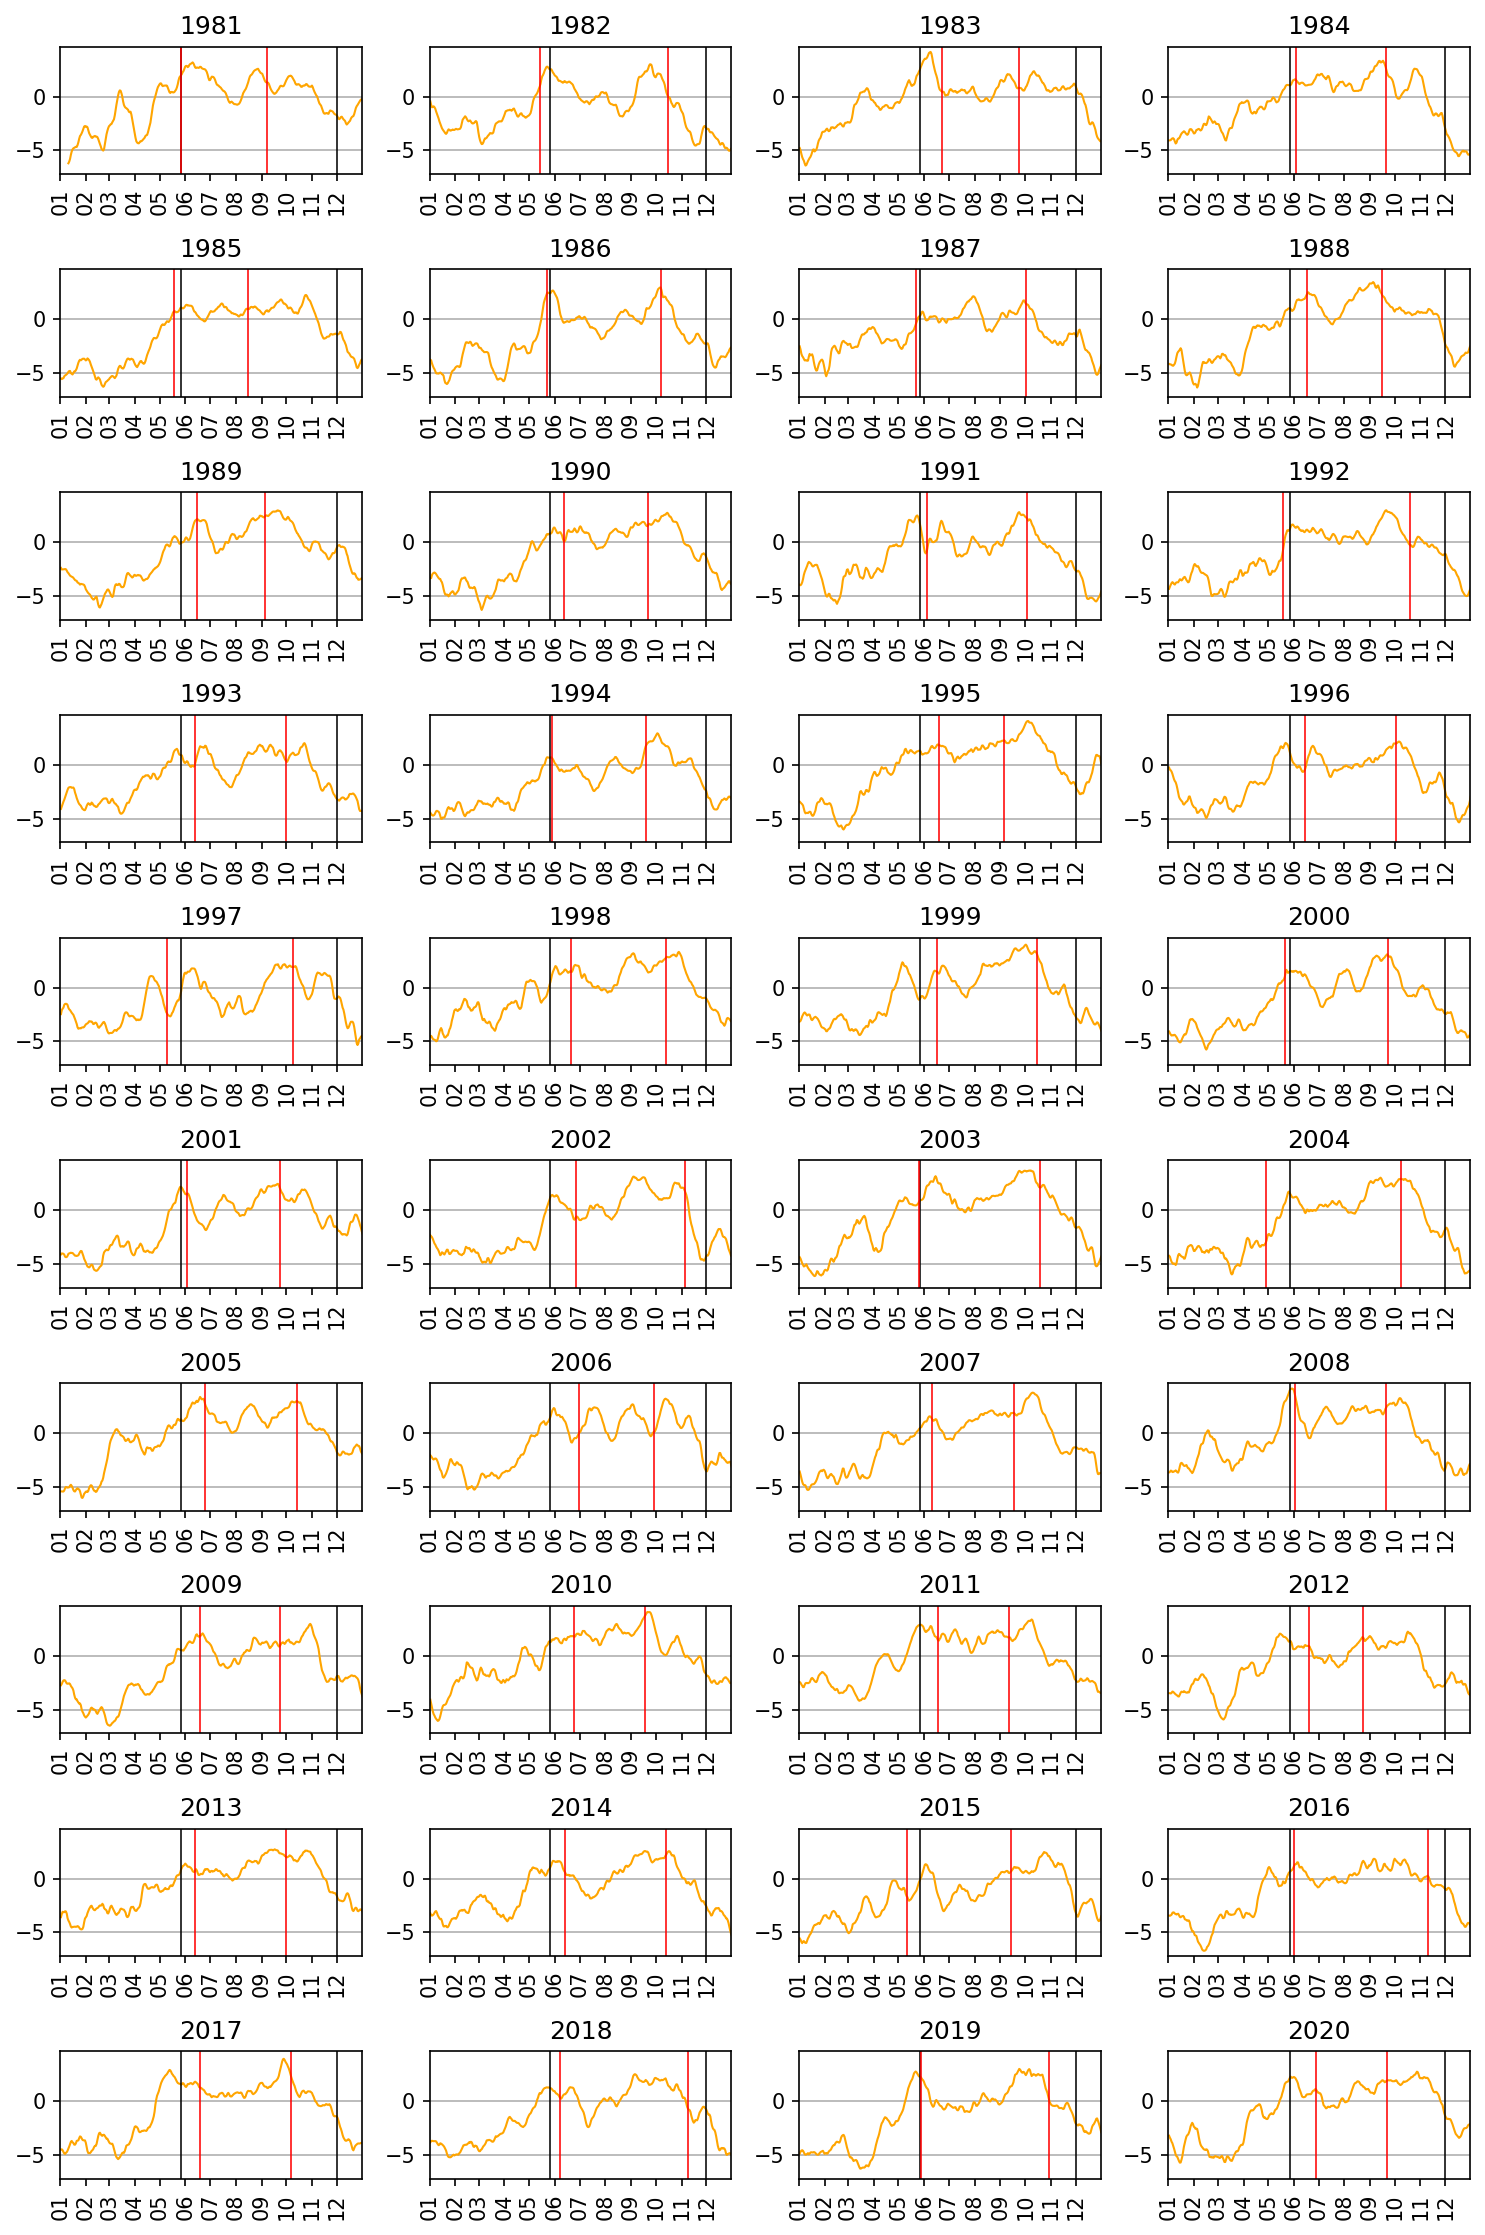

In [22]:
# Variable

# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = umbral_var
n = n_var

m_i = 4

df = pd.DataFrame(
    df_var.copy(), columns = ["Cuenca"] )
df_w = pd.DataFrame(
    df_var_w.copy(), columns = ["Cuenca"] )

years = range(1981, 2021)
c = "Cuenca"
title = "onset_withdrawal_CHIRPS_diferente.png"

# Onset.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[0]):
    proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
# Umbral positivo.
if umbral[0] >= 0:
    for i, p in enumerate(proc[1:]):
        df[p] = df[proc[0]].shift(i)
        df[p].clip( upper = umbral[0], inplace = True )
        df[p] = df[p].where( df[p] == umbral[0], 0 )
        df[p] = df[p].where( df[p] < umbral[0], 1 )
# Umbral negativo
if umbral[0] < 0:
    for i, p in enumerate(proc[1:]):
        df[p] = df[proc[0]].shift(i)
        df[p].clip( lower = umbral[0], inplace = True )
        df[p] = df[p].where( df[p] == umbral[0], 0 )
        df[p] = df[p].where( df[p] > umbral[0], 1 )
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df[ind] = 0
for i in range(n[0]): df[ind] += df[proc[i + 1]]
df[ind] = df[ind].where( df[ind] == n[0], 0 )
df[ind] = df[ind].where( df[ind] < n[0], 1 )
df[ind] = df[ind].where( df.index.month.isin( range(5, 12) ), 0 )
df.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df[ (df.index.year == j)
        & df.index.month.isin(range(m_i, 12)) ]
    row = []
    # Fechas.
    row.append( df_year.iloc[:, 1].idxmax() )
    row.append( None )
    #row.append( df_year.iloc[::-1, 1].idxmax() )
    # Agregamos la fila al DataFrame.
    date = date.append([row])
# Recorremos al inicio de la racha de días de precipitación.
#date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(n[0], 'D')
date.iloc[:, 0] = date.iloc[:, 0] + np.timedelta64(25, 'D')


# Withdrawal.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[1]): proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
# Umbral positivo.
if umbral[1] >= 0:
    for i, p in enumerate(proc[1:]):
        df_w[p] = df_w[proc[0]].shift(i)
        df_w[p].clip( upper = umbral[1], inplace = True )
        df_w[p] = df_w[p].where( df_w[p] == umbral[1], 0 )
        df_w[p] = df_w[p].where( df_w[p] < umbral[1], 1 )
# Umbral negativo
if umbral[1] < 0:
    for i, p in enumerate(proc[1:]):
        df_w[p] = df_w[proc[0]].shift(i)
        df_w[p].clip( lower = umbral[1], inplace = True )
        df_w[p] = df_w[p].where( df_w[p] == umbral[1], 0 )
        df_w[p] = df_w[p].where( df_w[p] > umbral[1], 1 )
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_w[ind] = 0
for i in range(n[1]): df_w[ind] += df_w[proc[i + 1]]
df_w[ind] = df_w[ind].where( df_w[ind] == n[1], 0 )
df_w[ind] = df_w[ind].where( df_w[ind] < n[1], 1 )
df_w[ind] = df_w[ind].where( df_w.index.month.isin( range(5, 12) ), 0 )
df_w.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date_2 = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_w[ (df_w.index.year == j)
        & df_w.index.month.isin(range(m_i, 12)) ]
    row = []
    # Fechas.
    row.append( None )
    #row.append( df_year.iloc[:, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax() )
    # Agregamos la fila al DataFrame.
    date_2 = date_2.append([row])
# Recorremos al inicio de la racha de días de precipitación.
#date_2.iloc[:, 1] = date_2.iloc[:, 1] - np.timedelta64(n[1], 'D')

# Unimos onset y withdrawal.
date.iloc[:, 1] = date_2.iloc[:, 1]

# Damos formato a las columnas y al índice.
date.columns = col
date.index = years
date.index.name = "Año"

# Longitud de la temporada.
date[name + " - Length"] = date.iloc[:, 1] - date.iloc[:, 0]

# Calculamos el shift necesario para alinear las fechas.
shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
shift_2 = date.iloc[:, 0].apply(lambda x: x.dayofyear)

date_var = date.copy()

# Guarda las series de tiempo.
#date.to_csv(path_d + "onset_CHIRPS.csv")
#shift.to_csv(path_d + "shift_CHIRPS.csv")
#shift_2.to_csv(path_d + "shift_withdrawal_CHIRPS.csv")

year = np.arange( 1981, 2021 )

#print(f"Onset     : {onset.day:02d}"
#    + f" {onset.month_name()}")
#print(f"Withdrawal: {withdrawal.day:02d}"
#    + f" {withdrawal.month_name()}")

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]

min_v = df.min().values[0] - 0.5
max_v = df.max().values[0] + 0.5

for i in range( len(year) ):
    df_year = df[ df.index.year == year[i] ]

    # Fechas.
    onset = date_var.iloc[date_var.index == year[i], 0]
    withdrawal = date_var.iloc[date_var.index == year[i], 1]

    onset_pre = date_pre.iloc[date_pre.index == year[i], 0]
    withdrawal_pre = date_pre.iloc[date_pre.index == year[i], 1]

    axes[i].plot(df_year.iloc[:, 0], color = "orange", linewidth = 1)
    #ax.plot(df_year.iloc[:, 1])

    # Onset y withdrawal.
    axes[i].plot( (onset, onset), (min_v, max_v),
        color = "k", linewidth = 0.75 )
    axes[i].plot( (withdrawal, withdrawal), (min_v, max_v), 
        color = "k", linewidth = 0.75 ) 

    axes[i].plot( (onset_pre, onset_pre), (min_v, max_v),
        color = "r", linewidth = 0.75 )
    axes[i].plot( (withdrawal_pre, withdrawal_pre), (min_v, max_v), 
        color = "r", linewidth = 0.75 ) 
    axes[i].set_title(year[i])
    #axes[i].set_yticks( range(min_v, 14, 4), minor = False )
    #axes[i].set_yticks( range(0, 14, 2), minor = True)
    axes[i].grid(axis = "y", which = "both")
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim(min_v, max_v)
    #axes[i].set_ylim(0, np.ceil(df_year.iloc[:, 0].max()) )
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
#fig.savefig( path_r + title )

print("rojo: precipitación")
print("negro: viento")

Wind onset: 27 May
Wind withdrawal: 01 December
rojo: precipitación
negro: viento


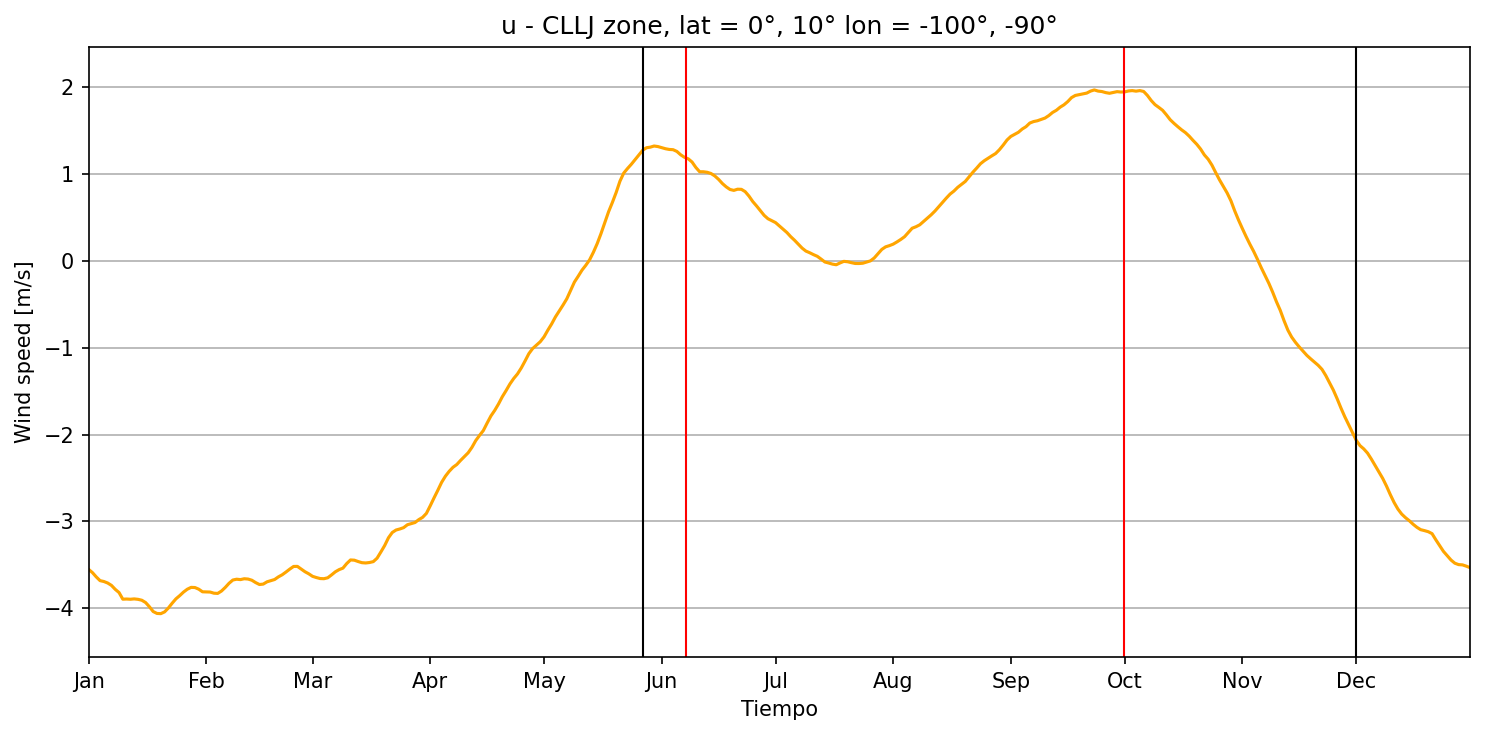

In [23]:
# Comportamiento anual de la variable y fechas medias de índices.

# Cargamos la fecha media de onset. 
date_1 = date_var.copy()
date_pre_1 = date_pre.copy()

# Promediamos las fechas
for i in [date_1, date_pre_1]:
    # Convertimos a día juliano.
    i.iloc[:, 0] = i.iloc[:, 0].apply(lambda x: x.dayofyear)
    i.iloc[:, 1] = i.iloc[:, 1].apply(lambda x: x.dayofyear)
    # Ajustamos los años bisiestos.
    i.iloc[i.index % 4 == 0, 0:2] = i.iloc[ i.index % 4 == 0, 0:2 ] - 1
    # Reconvertimos a fecha.
    i.iloc[:, 0] = ( pd.to_datetime("1995-01-01")
        + pd.to_timedelta(i.iloc[:, 0], "D") )
    i.iloc[:, 1] = ( pd.to_datetime("1995-01-01")
        + pd.to_timedelta(i.iloc[:, 1], "D") )

# Fechas medias.
onset = date_1.iloc[:, 0].mean()
onset_pre = date_pre_1.iloc[:, 0].mean()
withdrawal = date_1.iloc[:, 1].mean()
withdrawal_pre = date_pre_1.iloc[:, 1].mean()

pre_xr = clip.copy()

# Seleccionamos los años bisiestos.
leap_xr = pre_xr.sel(time = pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_leap = leap_xr.time.shape[0] / 365
# Ponderación para promedio.
leap_xr *= years_leap
# Promedio por día juliano.
leap_xr = leap_xr.groupby("time.dayofyear").mean()
# Corregimos los días de 1 a 365.
leap_xr["dayofyear"] = np.arange(1, 366)
# Dimensión para concatenar.
leap_xr = leap_xr.expand_dims("concat")

# Seleccionamos los años no bisiestos.
not_leap_xr = pre_xr.sel(time = ~pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_not_leap = not_leap_xr.time.shape[0] / 365  
# Ponderación para promedio.
not_leap_xr *= years_not_leap
# Promedio por día juliano.
not_leap_xr = not_leap_xr.groupby("time.dayofyear").mean()
# Dimensión para concatenar.
not_leap_xr = not_leap_xr.expand_dims("concat")

# Promedio ponderado de años bisiestos y no bisiestos.
pre_xr_mean = xr.concat( (not_leap_xr, leap_xr), "concat"
    ).mean("concat") * 2 / (years_leap + years_not_leap)

# Convertimos a DataFrame.
df_mean_2 = pre_xr_mean.mean( ["longitude", "latitude"]).to_dataframe()
df_mean_2.columns = ["Cuenca"]

# Cambiamos de dayofyear a fecha.
df_mean_2.index = pd.date_range( "1995-01-01", "1995-12-31", freq = "1D" )

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 5)
fig.set_dpi(150)

# Configuración de gráfica.
ax.plot( df_mean_2, color = "orange" )
ax.grid(axis = "y")
ax.set_title("u - CLLJ zone, lat = " + str(zones[1]) + "°, " + str(zones[3])
    + "° lon = " + str(zones[0]) + "°, " + str(zones[2]) + "°" )
ax.set_ylabel("Wind speed [m/s]")
ax.set_xlabel("Tiempo")
min_v = df_mean_2.min().values[0] - 0.5
max_v = df_mean_2.max().values[0] + 0.5
ax.set_ylim(min_v, max_v)
ax.set_xlim( pd.to_datetime("1995-01-01"), pd.to_datetime("1995-12-31") )
# Formato de fecha.
ax.xaxis.set_major_locator( mdates.MonthLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter("%b") )

# Onset.
ax.plot( (onset, onset), (min_v, max_v),
    color = "k", linewidth = 1 )
ax.plot( (onset_pre, onset_pre), (min_v, max_v),
    color = "r", linewidth = 1 )
print(f"Wind onset: {onset.day:02d}" + f" {onset.month_name()}")

#W ithdrawal.
ax.plot( (withdrawal, withdrawal), (min_v, max_v),
    color = "k", linewidth = 1 )
ax.plot( (withdrawal_pre, withdrawal_pre), (min_v, max_v),
    color = "r", linewidth = 1 )
print(f"Wind withdrawal: {withdrawal.day:02d}" + f" {withdrawal.month_name()}")

# Separación adecuada entre gráficas.
fig.tight_layout()

#fig.savefig( path_r + "u_mean_CLLJ.png", bbox_inches = "tight" )

print("rojo: precipitación")
print("negro: viento")

Onset correlation     : -0.108
Withdrawal correlation: -0.019


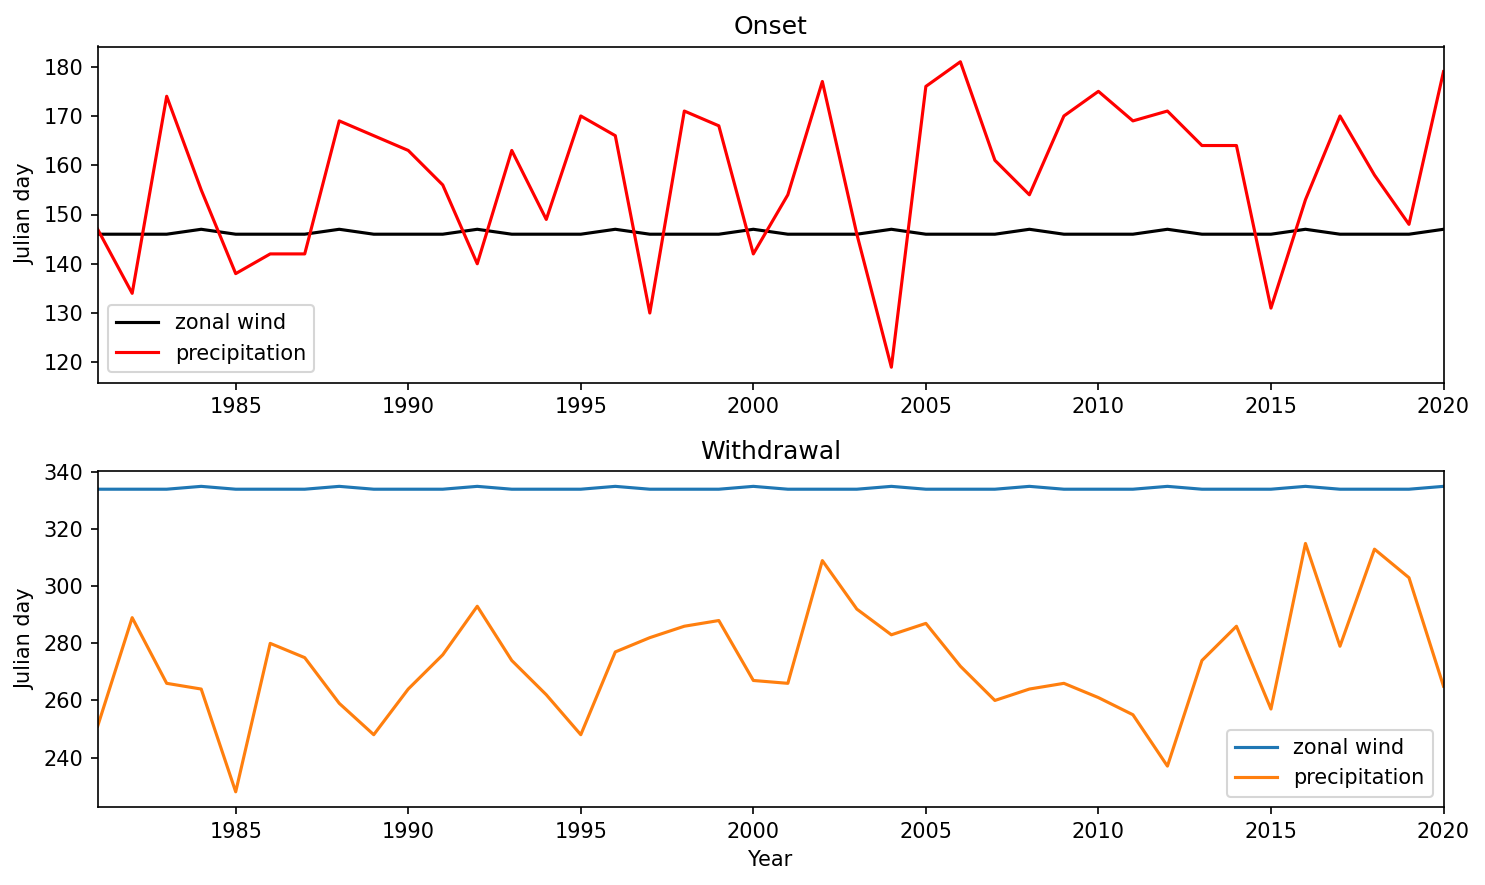

In [24]:
# Correlación entre índice de precipitación y de viento.

c_date = date_var.copy()
c_date_pre = date_pre.copy()

# Se convierten las fechas a días julianos.
c_date["Cuenca - Onset"] = c_date["Cuenca - Onset"].apply(
    lambda x: pd.to_datetime(x))
c_date["Cuenca - Onset"] = c_date["Cuenca - Onset"].apply(
    lambda x: x.dayofyear)
c_date["Cuenca - Withdrawal"] = c_date["Cuenca - Withdrawal"].apply(
    lambda x: pd.to_datetime(x))
c_date["Cuenca - Withdrawal"] = c_date["Cuenca - Withdrawal"].apply(
    lambda x: x.dayofyear)

# Se convierten las fechas a días julianos.
c_date_pre["Cuenca - Onset"] = c_date_pre["Cuenca - Onset"].apply(
    lambda x: pd.to_datetime(x))
c_date_pre["Cuenca - Onset"] = c_date_pre["Cuenca - Onset"].apply(
    lambda x: x.dayofyear)
c_date_pre["Cuenca - Withdrawal"] = c_date_pre["Cuenca - Withdrawal"].apply(
    lambda x: pd.to_datetime(x))
c_date_pre["Cuenca - Withdrawal"] = c_date_pre["Cuenca - Withdrawal"].apply(
    lambda x: x.dayofyear)

# Media móvil.
#l = 20
#c_date_pre["Onset - Mean"] = c_date_pre["Cuenca - Onset"
#    ].rolling(window = l).mean()
#c_date_pre["Withdrawal - Mean"] = c_date_pre["Cuenca - Withdrawal"
#    ].rolling(window = l).mean()
#c_date["Onset - Mean"] = c_date["Cuenca - Onset"
#    ].rolling(window = l).mean()
#c_date["Withdrawal - Mean"] = c_date["Cuenca - Withdrawal"
#    ].rolling(window = l).mean()

# Graficamos.
#fig, axes = plt.subplots(4)
fig, axes = plt.subplots(2)
fig.set_facecolor("w")
#fig.set_size_inches(10, 12)
fig.set_size_inches(10, 6)
fig.set_dpi(150)

c_date["Cuenca - Onset"].plot(ax = axes[0], color = "k")
c_date_pre["Cuenca - Onset"].plot(ax = axes[0], color = "r")
#c_date["Onset - Mean"].plot(ax = axes[1], color = "k")
#c_date_pre["Onset - Mean"].plot(ax = axes[1], color = "r")

c_date["Cuenca - Withdrawal"].plot(ax = axes[1])
c_date_pre["Cuenca - Withdrawal"].plot(ax = axes[1])
#c_date["Withdrawal - Mean"].plot(ax = axes[3])
#c_date_pre["Withdrawal - Mean"].plot(ax = axes[3])

# Formato de ejes.
for ax in axes:
    ax.set_ylabel("Julian day")
    ax.legend( ["zonal wind", "precipitation"] )
    ax.set_xlabel("")
#for ax in axes[0::2]:
for ax in axes:
    ax.set_xlim(1981, 2020)
#for ax in axes[1::2]:
#    ax.set_xlim(1981 + l, 2020)
#    # El eje tiene puras marcas enteras.
#    ax.xaxis.set_major_locator( ticker.MaxNLocator(integer = True) )
ax.set_xlabel("Year")

axes[0].set_title("Onset")
#axes[1].set_title(f"Rolling mean: {l} years")
axes[1].set_title("Withdrawal")
#axes[3].set_title(f"Rolling mean: {l} years")

# Correlaciones de las series.
corr = []
corr.append( c_date["Cuenca - Onset"].corr( c_date_pre["Cuenca - Onset"] ) )
#corr.append( c_date["Onset - Mean"].corr( c_date_pre["Onset - Mean"] ) )
corr.append( c_date["Cuenca - Withdrawal"].corr(
    c_date_pre["Cuenca - Withdrawal"] ) )
print(f"Onset correlation     : {corr[0]:.3f}")
#print(f"Onset 20 year av. correlation: {corr[1]:.3f}")
print(f"Withdrawal correlation: {corr[1]:.3f}")

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "comparacion_viento_pre.png")